<a href="https://colab.research.google.com/github/ahmedoumar/IndeedJobClassification/blob/main/IndeedJobClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets gdown pytorch_lightning torchmetrics tensorboard wandb

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import wandb
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import nn
import pytorch_lightning as pl
from torchmetrics import F1Score, Accuracy
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
#drive.mount('/content/gdrive/')
import tensorboard

import warnings
warnings.filterwarnings('ignore')
pl.seed_everything()

INFO:pytorch_lightning.utilities.seed:Global seed set to 3833614091


3833614091

In [ ]:
data = pd.read_csv('data.csv')
data['label'] = 'data'
data['content'] = data['title']+' '+data['snippet']
data.head()

,title,snippet,label,content
0,STAGIAIRE DATA SCIENCE,"Sous la supervision d'un data scientist, le st...",data,STAGIAIRE DATA SCIENCE Sous la supervision d'u...
1,Data Scientist Assistant - Stage (F/H/NB),Concevoir des systèmes utilisant du Natural La...,data,Data Scientist Assistant - Stage (F/H/NB) Conc...
2,Ingénieur-e en géomatique / data science,Formation recommandée *: Vous devez être titul...,data,Ingénieur-e en géomatique / data science Forma...
3,ALTERNANCE - DATA SCIENCE / DEVELOPPEMENT IA F/H,"Dans une démarche d’industrie 4.0, Ingérop s’i...",data,ALTERNANCE - DATA SCIENCE / DEVELOPPEMENT IA F...
4,Docteur R&D – Data Science / Machine Learning ...,En finalisation d’une levée de fonds et dans l...,data,Docteur R&D – Data Science / Machine Learning ...


In [ ]:
rh = pd.read_csv('RH.csv')
rh['label'] = 'RH'
rh['content'] = rh['title']+' '+rh['snippet']
rh.head()

,title,snippet,label,content
0,Chargé RH H/F,Contribution au process de recrutement (diffus...,RH,Chargé RH H/F Contribution au process de recru...
1,Assistant RH et Administratif (H/F),Gestion du disciplinaire - Mise en place et su...,RH,Assistant RH et Administratif (H/F) Gestion du...
2,Responsable RH H/F,Des déplacements réguliers sont à prévoir sur ...,RH,Responsable RH H/F Des déplacements réguliers ...
3,Assistant RH H/F,FAYAT POWER regroupe les activités de producti...,RH,Assistant RH H/F FAYAT POWER regroupe les acti...
4,GUCCI_Chargé(e) d'études RH,Le Chargé(e) d’études RH est en charge de gére...,RH,GUCCI_Chargé(e) d'études RH Le Chargé(e) d’étu...


In [ ]:
design = pd.read_csv('design.csv')
design['label'] = 'design'
design['content'] = design['title']+' '+design['snippet']
design.head()

,title,snippet,label,content
0,Visual Design Intern,Celebrating unconventional aesthetics and embr...,design,Visual Design Intern Celebrating unconventiona...
1,Design Consultant,5 years of higher education - Degree in archit...,design,Design Consultant 5 years of higher education ...
2,Designer junior – H/F,Learn to design and format in the agency’s cre...,design,Designer junior – H/F Learn to design and form...
3,BALENCIAGA – Junior Graphic Designer (F/M),A person with creative and innovative design s...,design,BALENCIAGA – Junior Graphic Designer (F/M) A p...
4,Responsable artistique et design (H/F),Participer à la réalisation des dispositifs de...,design,Responsable artistique et design (H/F) Partici...


In [ ]:
web = pd.read_csv('web.csv')
web['label'] = 'web'
web['content'] = web['title']+' '+web['snippet']
web.head()

,title,snippet,label,content
0,Développeur web junior,Gérer les environnements locaux (Souces / Serv...,web,Développeur web junior Gérer les environnement...
1,Développeur web Frontend H/F,Leihia est la première plateforme digitale qui...,web,Développeur web Frontend H/F Leihia est la pre...
2,Développeur F/H,Notre client est spécialisé dans la transforma...,web,Développeur F/H Notre client est spécialisé da...
3,Développeur Java Junior (F/H),Développeur.euse Back-end Java avec une premiè...,web,Développeur Java Junior (F/H) Développeur.euse...
4,APPRENTI(E) DEVELOPPEUR WEB (H/F),Assurer la maintenance corrective des portails...,web,APPRENTI(E) DEVELOPPEUR WEB (H/F) Assurer la m...


In [ ]:
all_data = pd.concat([rh, data, design, web], axis=0)
# Remove duplicates:
all_data.drop_duplicates(inplace=True)
all_data

,title,snippet,label,content
0,Chargé RH H/F,Contribution au process de recrutement (diffus...,RH,Chargé RH H/F Contribution au process de recru...
1,Assistant RH et Administratif (H/F),Gestion du disciplinaire - Mise en place et su...,RH,Assistant RH et Administratif (H/F) Gestion du...
2,Responsable RH H/F,Des déplacements réguliers sont à prévoir sur ...,RH,Responsable RH H/F Des déplacements réguliers ...
3,Assistant RH H/F,FAYAT POWER regroupe les activités de producti...,RH,Assistant RH H/F FAYAT POWER regroupe les acti...
4,GUCCI_Chargé(e) d'études RH,Le Chargé(e) d’études RH est en charge de gére...,RH,GUCCI_Chargé(e) d'études RH Le Chargé(e) d’étu...
...,...,...,...,...
188,Un developpeur Web sur Montrouge / Freelance,Almatek recherche pour un de ses clients un de...,web,Un developpeur Web sur Montrouge / Freelance A...
189,DEVELOPPEUR INTEGRATEUR WEB H/F,"TES MISSIONS, SI TU LES ACCEPTES, SERONT LES S...",web,"DEVELOPPEUR INTEGRATEUR WEB H/F TES MISSIONS, ..."
190,Collaborateurs Développeurs Web,Type de contrat : à définir.Pour lesquels les ...,web,Collaborateurs Développeurs Web Type de contra...
201,DEVELOPPEUR WinDev H/H,Au sein de l’équipe Informatique et rattaché a...,web,DEVELOPPEUR WinDev H/H Au sein de l’équipe Inf...


In [ ]:
len(all_data)

243

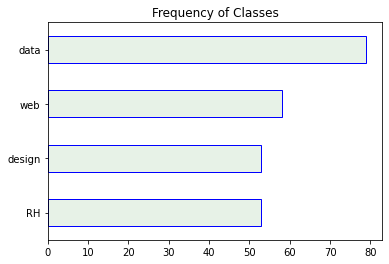

In [ ]:
all_data['label'].value_counts(ascending=True).plot.barh(color=(0.1, 0.5, 0.1, 0.1),  edgecolor='blue')
plt.title('Frequency of Classes')
plt.show()

In [ ]:
train_data, val_data = train_test_split(all_data, test_size=.2)

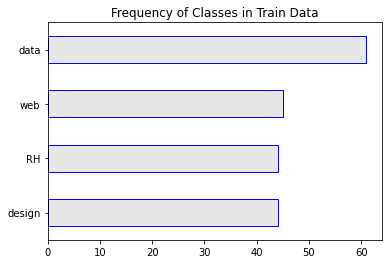

In [ ]:
train_data['label'].value_counts(ascending=True).plot.barh(color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
plt.title('Frequency of Classes in Train Data')
plt.show()

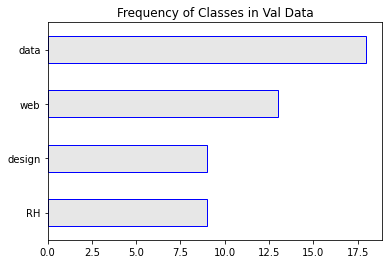

In [ ]:
val_data['label'].value_counts(ascending=True).plot.barh(color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
plt.title('Frequency of Classes in Val Data')
plt.show()

In [ ]:
num_labels = len(all_data.label.unique())
label_encoder = LabelEncoder()

train_data['label'] = label_encoder.fit_transform(train_data['label'])
val_data['label'] = label_encoder.transform(val_data['label'])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Config:
    lr = 4e-5
    max_len = 256
    train_bs = 32
    val_bs = 32
    train_pcent = .99
    #num_workers = 8
    bert_model = 'bert-base-multilingual-cased' #'aubmindlab/bert-base-arabert'#'# CAMeL-Lab/bert-base-arabic-camelbert-ca
    tokenizer = AutoTokenizer.from_pretrained(bert_model)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, content, target):
        self.content = content
        self.target = target
        self.tokenizer = Config.tokenizer
        self.max_len = Config.max_len
        
    def __len__(self):
        return len(self.content)
    
    def __getitem__(self, idx):
        content = str(self.content[idx])
        #columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder='passthrough')
        #targets = np.array(columnTransformer.transform(targets), dtype = np.str)

        inputs = self.tokenizer.encode_plus(
            content,
            None,
            max_length=Config.max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            truncation='longest_first',
            return_attention_mask=True,
            #return_tensors='pt'
        )

        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        targets = torch.tensor(self.target[idx], dtype=torch.long)

        return {
            'ids': ids,
            'mask': mask,
            'token_type_ids': token_type_ids,
            'targets': targets
        }

In [ ]:
"""#bert = transformers.AutoModelForSequenceClassification.from_pretrained(Config.bert_model, num_labels=num_labels)
#bert
!pip install sadice
from sadice import SelfAdjDiceLoss
!pip install focal_loss_torch
from focal_loss.focal_loss import FocalLoss
"""
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=10,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
wandb.login()

wandb: Currently logged in as: ahmedoumar (ahmed_khalil). Use `wandb login --relogin` to force relogin


True

In [ ]:
run = wandb.init(project='IndeedClassification', reinit='True', config=Config())

In [ ]:
f1 = F1Score(num_classes=num_labels)

class Bert(pl.LightningModule):
    def __init__(self) -> None:
        super(Bert, self).__init__()
        self.bert = transformers.AutoModel.from_pretrained(Config.bert_model)
        self.drop = nn.Dropout(.2)
        self.layer1 = nn.Linear(768, 512)
        self.layer2 = nn.Linear(768, num_labels)
        self.leaky_relu = nn.LeakyReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        self.train_loss_fn = FocalLoss()# Better without Class weights.
        self.val_loss_fn = FocalLoss()
        
        self.f1_train = F1Score(num_classes=num_labels, average='macro')
        self.f1_val = F1Score(num_classes=num_labels, average='macro')
        self.acc_train = Accuracy()
        self.acc_val = Accuracy()
        
        self.all_targets = []
        self.train_df = MyDataset(train_data['content'].values, 
                                  train_data['label'].values)
        self.val_df = MyDataset(val_data['content'].values,
                                val_data['label'].values)

    def forward(self, ids, mask, token_type_ids) -> torch.Tensor:
        _, output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        #output = self.drop(output)
        #output = self.layer1(output)
        #output = self.leaky_relu(output)
        #output = self.drop(output)
        output = self.layer2(output)
        output = self.log_softmax(output)
        #print(output.shape)
        return output

    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_df,
            batch_size=Config.train_bs,
            shuffle=False,
            #num_workers = Config.num_workers
        )
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(
            self.val_df,
            batch_size=Config.val_bs,
            shuffle=False,
            #num_workers=Config.num_workers
        )
        return val_loader

    def training_step(self, batch, batch_idx):
        ids = batch['ids'].long()
        mask = batch['mask'].long()
        token_type_ids = batch['token_type_ids'].long()
        targets = batch['targets'].long()

        outputs = self(ids=ids, mask=mask, token_type_ids=token_type_ids)
        train_loss = self.train_loss_fn(outputs, targets)
        
        self.f1_train(torch.argmax(outputs, dim=-1), targets)
        #f1_train = f1_score(targets.cpu().data.numpy(), outputs.cpu().data.numpy().argmax(-1), average='weighted')
        self.acc_train(torch.argmax(outputs, dim=-1), targets)
        
        self.log('Train_Loss', train_loss, on_step=False, prog_bar=True, on_epoch=True, logger=True)
        self.log('F1_Train', self.f1_train, on_step=False,prog_bar=True, on_epoch=True, logger=True)
        self.log('Train_Acc', self.acc_train, on_step=False, prog_bar=True, on_epoch=True, logger=True)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        ids = batch['ids'].long()
        mask = batch['mask'].long()
        token_type_ids = batch['token_type_ids'].long()
        targets = batch['targets'].long()

        outputs = self(ids=ids, mask=mask, token_type_ids=token_type_ids)
        self.all_targets.extend(targets.cpu().detach().numpy().tolist())
        val_loss = self.val_loss_fn(outputs, targets)
        #print('Outputs shape: ', outputs.shape)
        #print('Targets shape: ', targets.shape)
        self.f1_val(torch.argmax(outputs, dim=-1), targets)
        self.acc_val(torch.argmax(outputs, dim=-1), targets)
        
        self.log('Val Loss', val_loss, on_step=False,prog_bar=True, on_epoch=True, logger=True)
        self.log('F1 Val', self.f1_val, on_step=False,prog_bar=True, on_epoch=True, logger=True)
        self.log('Acc_Val', self.acc_val, on_step=False,prog_bar=True, on_epoch=True, logger=True)
        
        return val_loss
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=Config.lr)
    
    

In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger

In [ ]:
logger = WandbLogger(project='IndeedClassification', 
                           config=Config,
                           job_type='train')

In [ ]:
model = Bert()

#wandb.watch(model, FocalLoss(), log='all', log_freq=10)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainer = pl.Trainer(max_epochs=6, gpus=1,enable_progress_bar=True,
                    logger=logger)
hist = trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type       | Params
----------------------------------------------
0  | bert          | BertModel  | 177 M 
1  | drop          | Dropout    | 0     
2  | layer1        | Linear     | 393 K 
3  | layer2        | Linear     | 3.1 K 
4  | leaky_relu    | LeakyReLU  | 0     
5  | log_softmax   | LogSoftmax | 0     
6  | train_loss_fn | FocalLoss  | 0     
7  | val_loss_fn   | FocalLoss  | 0     
8  | f1_train      | F1Score    | 0     
9  | f1_val        | F1Score    | 0     
10 | acc_train     | Accuracy   | 0     
11 | a

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [ ]:
wandb.finish()

Acc_Val,▁▅██▇▇
F1 Val,▁▅██▇▇
F1_Train,▁▅▇███
Train_Acc,▁▅▆███
Train_Loss,█▃▁▁▁▁
Val Loss,█▂▁▁▁▁
epoch,▁▁▂▂▄▄▅▅▇▇██
trainer/global_step,▁▁▂▂▄▄▅▅▇▇██
Acc_Val,0.89796
F1 Val,0.88172
F1_Train,0.90127


In [ ]:
from tqdm import tqdm
model.eval()
predictions = []
def predict(data):
    #for input_txt in tqdm(data):
    tokenized = Config.tokenizer(data, 
                                return_tensors='pt',
                                truncation=True, padding=True, max_length=Config.max_len)
    output = model(ids=tokenized['input_ids'], mask=tokenized['attention_mask'], 
                    token_type_ids=tokenized['token_type_ids'])
    
    pred = torch.argmax(output, dim=1)
    pred = label_encoder.inverse_transform(pred)
    predictions.append(pred)
    return predictions

prediction = predict("""Dans le cadre de la création de notre 3ème Squad, nous recherchons plusieurs dév web fullstack
Si tu es un.e développeur.se passionné.e qui est prêt.e à nous aider à améliorer nos produits, à développer nos nouvelles fonctionnalités : cette offre est faite pour toi !

Au sein de l’équipe Tech / Data & Produit composée d’une vingtaine de personnes, tu feras partie d’une Squad (5 dev).""")

print(prediction)

[array(['web'], dtype=object)]


In [ ]:
all_data.content

0      Chargé RH H/F Contribution au process de recru...
1      Assistant RH et Administratif (H/F) Gestion du...
2      Responsable RH H/F Des déplacements réguliers ...
3      Assistant RH H/F FAYAT POWER regroupe les acti...
4      GUCCI_Chargé(e) d'études RH Le Chargé(e) d’étu...
                             ...                        
188    Un developpeur Web sur Montrouge / Freelance A...
189    DEVELOPPEUR INTEGRATEUR WEB H/F TES MISSIONS, ...
190    Collaborateurs Développeurs Web Type de contra...
201    DEVELOPPEUR WinDev H/H Au sein de l’équipe Inf...
202    DEVELOPPEUR RPG AS400 Développer avec le langa...
Name: content, Length: 243, dtype: object

In [ ]:
torch.save(model, 'IndeedJobClassifier.pt')